device=CPU, Hash=0
K =  1, T = 11, Run-time =   11.48 (sec.)

Plotting .... 


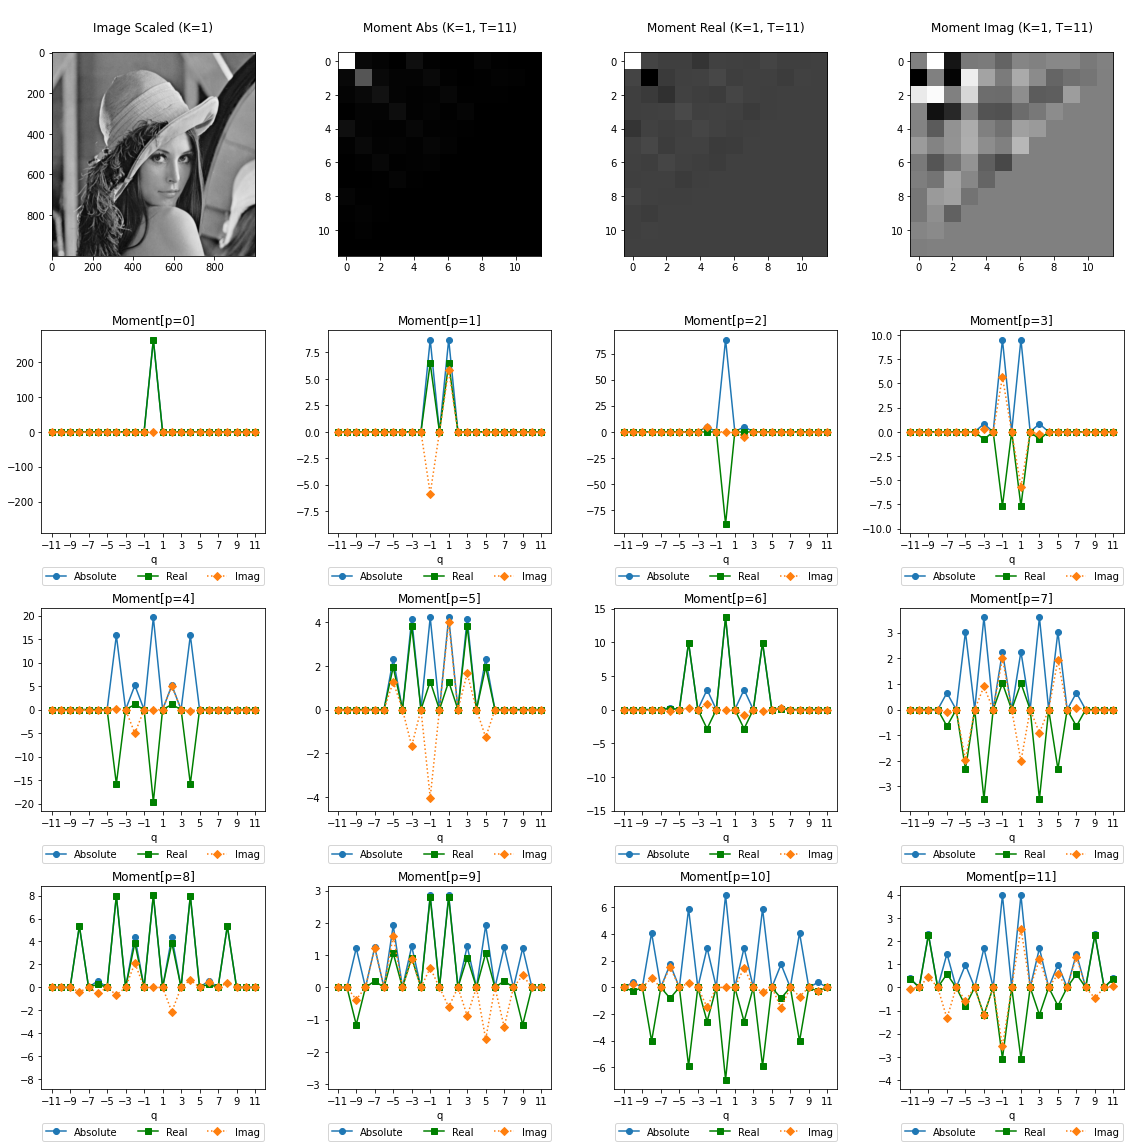


                      0                   1                   2   \
0   264.774138+0.000000j  0.000000+0.000000j  0.000000+0.000000j   
1   0.0000000+0.0000000j  6.462715+5.850329j  0.000000+0.000000j   
2   -88.554443+0.000000j  0.000000+0.000000j -0.266867-4.855508j   
3   0.0000000+0.0000000j -7.677367-5.652586j  0.000000+0.000000j   
4   -19.625247+0.000000j  0.000000+0.000000j  1.094394+5.045768j   
5   0.0000000+0.0000000j  1.283618+4.021320j  0.000000+0.000000j   
6    13.715922+0.000000j  0.000000+0.000000j -2.842831-0.846432j   
7   0.0000000+0.0000000j  1.032257-2.012394j  0.000000+0.000000j   
8   8.0377920+0.0000000j  0.000000+0.000000j  3.867099-2.119867j   
9   0.0000000+0.0000000j  2.799032-0.605622j  0.000000+0.000000j   
10 -6.9229210+0.0000000j  0.000000+0.000000j -2.558935+1.487496j   
11  0.0000000+0.0000000j -3.069119+2.540679j  0.000000+0.000000j   

                    3                    4                   5   \
0   0.000000+0.000000j   0.000000+0.000000j  0.

In [5]:
%%time

from IPython.display import clear_output
clear_output()

# 저니크 모멘트 계산 

from AZernike import *

# 모멘트 특징 표시 
debug = 0

use_gpu    = 1
use_thread = 0
use_hash   = 0

K = 1 # 2
T = 11 # 10 
feature_info = {}

img = cv.imread( 'image/lenna.png', 0 ) 
img_name = "lena"
            
test_zernike_features( feature_info, img_name, img, use_gpu, use_thread, use_hash, K, T, debug=debug ) 

plot_moment_features( feature_info, img_name, use_gpu=use_gpu )

print( "Done." )


device=CPU, Hash=0
K =  1, T = 11, Run-time =   11.50 (sec.)

Plotting .... 


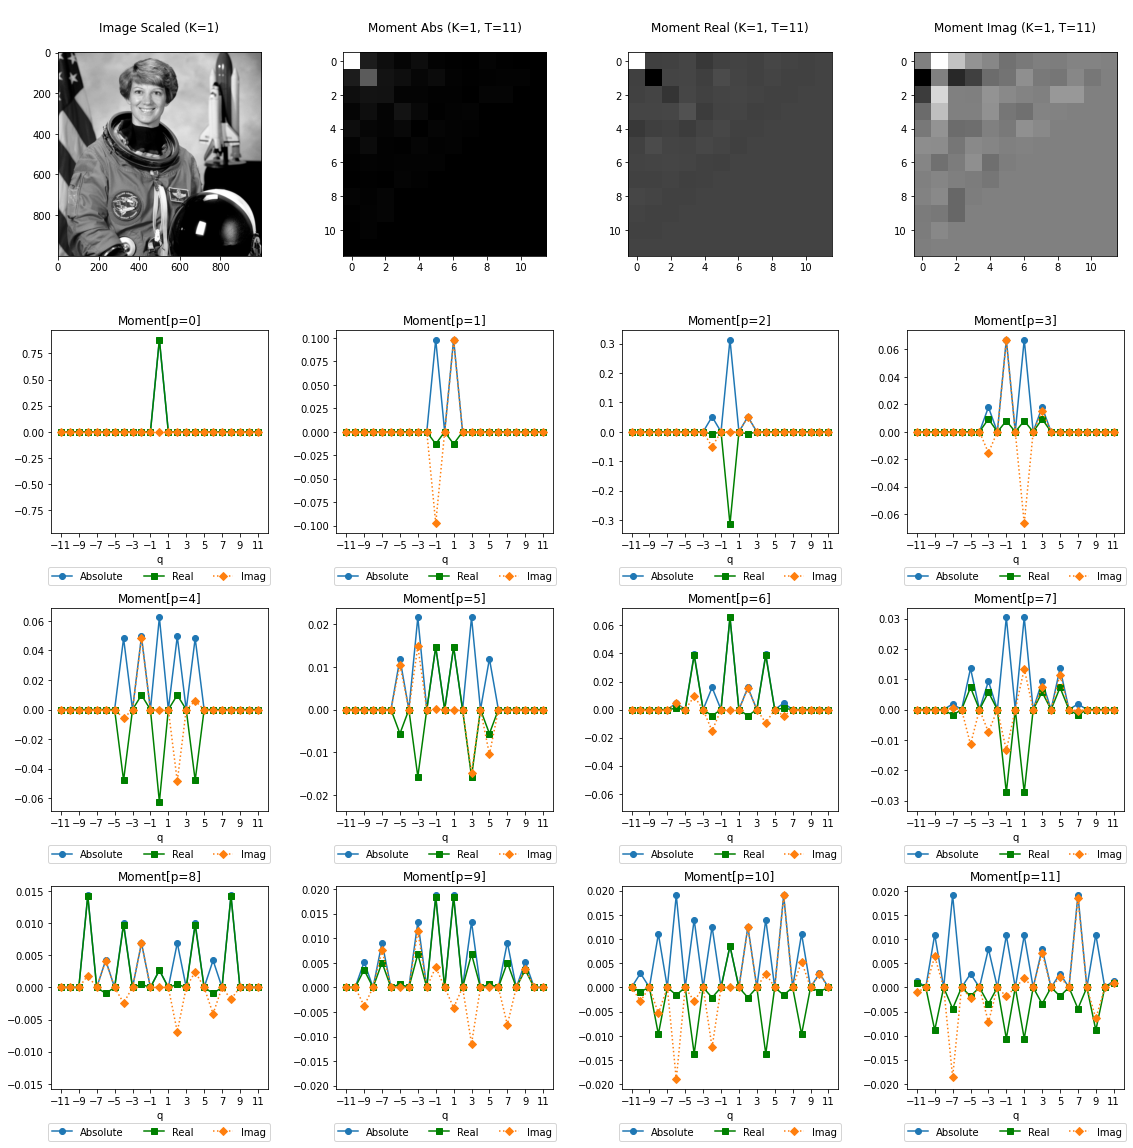


                    0                   1                   2   \
0   0.883907+0.000000j  0.000000+0.000000j  0.000000+0.000000j   
1   0.000000+0.000000j -0.012967+0.097446j  0.000000+0.000000j   
2  -0.314398+0.000000j  0.000000+0.000000j -0.007546+0.050764j   
3   0.000000+0.000000j  0.007958-0.066721j  0.000000+0.000000j   
4  -0.062450+0.000000j  0.000000+0.000000j  0.009862-0.048509j   
5   0.000000+0.000000j  0.014617-0.000112j  0.000000+0.000000j   
6   0.065782+0.000000j  0.000000+0.000000j -0.004362+0.015152j   
7   0.000000+0.000000j -0.027295+0.013459j  0.000000+0.000000j   
8   0.002677+0.000000j  0.000000+0.000000j  0.000479-0.006888j   
9   0.000000+0.000000j  0.018324-0.004131j  0.000000+0.000000j   
10  0.008562+0.000000j  0.000000+0.000000j -0.002105+0.012395j   
11  0.000000+0.000000j -0.010612+0.001882j  0.000000+0.000000j   

                    3                   4                   5   \
0   0.000000+0.000000j  0.000000+0.000000j  0.000000+0.000000j   
1   0.00

In [4]:
%%time

from IPython.display import clear_output
clear_output()

# 저니크 모멘트 계산 

from AZernike import *

# 모멘트 특징 표시 
debug = 0

use_gpu    = 1
use_thread = 0
use_hash   = 0

K = 1 # 2
T = 11 # 10 
feature_info = {}

# 예제 이미지 데이터
img_infos =  [ 
    { "title" : "lena",         "img" : rgb2gray( io.imread( 'image/lenna.png' ) ) } , 
    { "title" : "astronaut",    "img" : rgb2gray( data.astronaut() )} ,
    { "title" : "camera",       "img" : data.camera() },
    
    { "title" : "brick",        "img" : data.brick() },    
    { "title" : "moon",         "img" : data.moon() },
    { "title" : "grass",        "img" : data.grass() },   
]

img = rgb2gray( data.astronaut() )
img_name = "astronaut"
            
test_zernike_features( feature_info, img_name, img, use_gpu, use_thread, use_hash, K, T, debug=debug ) 

plot_moment_features( feature_info, img_name, use_gpu=use_gpu )

print( "Done." )